## Lecture 1:  Linear Regression

Outline & Recommended Readings:
- Introduction to Machine Learning: https://www.ibm.com/cloud/learn/machine-learning
- Machine Learning terminology: https://medium.com/technology-nineleaps/some-key-machine-learning-definitions-b524eb6cb48
- Supervised vs. Unsupervised Learning: https://www.ibm.com/cloud/blog/supervised-vs-unsupervised-learning
- Linear Regression: https://see.stanford.edu/materials/aimlcs229/cs229-notes1.pdf (pp. 3 - 15)
- Lasso and Ridge Regression: https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
- k-fold cross-validation: https://machinelearningmastery.com/k-fold-cross-validation/

Other Fun Articles:
- Wine Equation Puts Some Noses Out of Joint (NYT 1990): https://www.nytimes.com/1990/03/04/us/wine-equation-puts-some-noses-out-of-joint.html

In [1]:
# general data science packages
import numpy as np
import pandas as pd

# specific packages for regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# graphing packages
import matplotlib.pyplot as plt
import seaborn as sns

# other helpful packages
from tqdm import tqdm

### Example 1: Simple Linear Regression
For this part, we will be using the Ashenfelter wine data set (source: https://raw.githubusercontent.com/egarpor/handy/master/datasets/wine.csv)

In [2]:
# import wine dataset
df = pd.read_csv('./data/wine/wine.csv')
df.head()  # remove '.head()' if you want to view the full dataframe

,Year,Price,WinterRain,AGST,HarvestRain,Age,FrancePop
0,1952,7.4950,600,17.1167,160,31,43183.569
1,1953,8.0393,690,16.7333,80,30,43495.030
2,1955,7.6858,502,17.1500,130,28,44217.857
3,1957,6.9845,420,16.1333,110,26,45152.252
4,1958,6.7772,582,16.4167,187,25,45653.805


As we can see, this dataset contains 7 attributes and 27 rows. A quick summary of each attribute can be found below.

Note that AGST stands for Average Growing Season Temperature in degrees Celsius and FrancePop represents the population of France in thousands.

In [3]:
df.describe()

,Year,Price,WinterRain,AGST,HarvestRain,Age,FrancePop
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,1966.814815,7.041948,608.407407,16.477781,144.814815,16.185185,50085.443963
std,8.246384,0.634590,129.034956,0.659189,73.065849,8.246384,3792.998764
min,1952.000000,6.204900,376.000000,14.983300,38.000000,3.000000,43183.569000
25%,1960.500000,6.508350,543.500000,16.150000,88.000000,9.500000,46856.000000
50%,1967.000000,6.984500,600.000000,16.416700,123.000000,16.000000,50650.406000
75%,1973.500000,7.441500,705.500000,17.008350,185.500000,22.500000,53511.207500
max,1980.000000,8.493700,830.000000,17.650000,292.000000,31.000000,55110.236000


Our goal is to predict the quality of the wine. Since we do not have an exact value for the quality of the wine, we can use the Price as a close estimate (since it is reasonable to assume that Price and Quality are strongly correlated).

Our first step is to plot the data to identify any trends which may be helpful for our regression. In general it is always a good idea to visualize your data (for reasons why you should not trust summary statistics alone, check out [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) or the [Datasaurus Dozen](https://juliasilge.com/blog/datasaurus-multiclass/).

<AxesSubplot:xlabel='Year', ylabel='Price'>

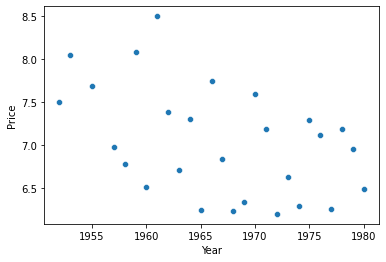

In [4]:
sns.scatterplot(data=df, x='Year', y='Price')

<AxesSubplot:xlabel='WinterRain', ylabel='Price'>

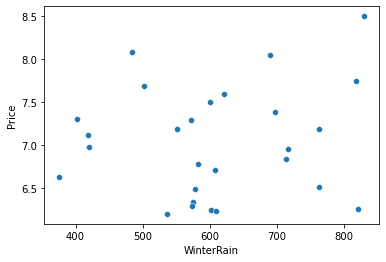

In [5]:
sns.scatterplot(data=df, x='WinterRain', y='Price')

<AxesSubplot:xlabel='AGST', ylabel='Price'>

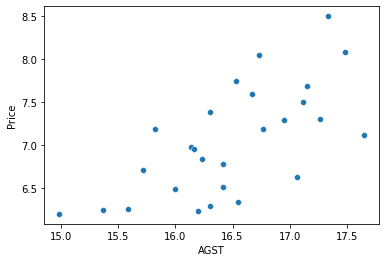

In [6]:
sns.scatterplot(data=df, x='AGST', y='Price')

<AxesSubplot:xlabel='AGST', ylabel='Price'>

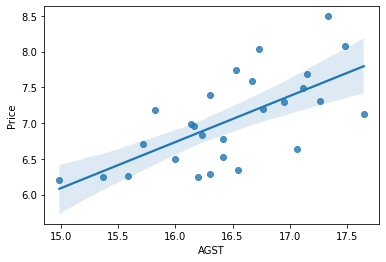

In [7]:
sns.regplot(data=df, x='AGST', y='Price')

<AxesSubplot:xlabel='HarvestRain', ylabel='Price'>

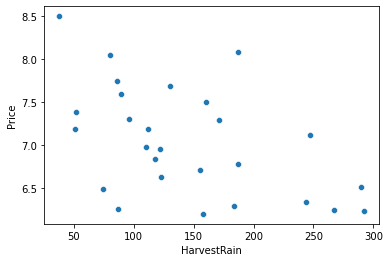

In [8]:
sns.scatterplot(data=df, x='HarvestRain', y='Price')

The following code shows all of the pairwise relationships in the dataset.

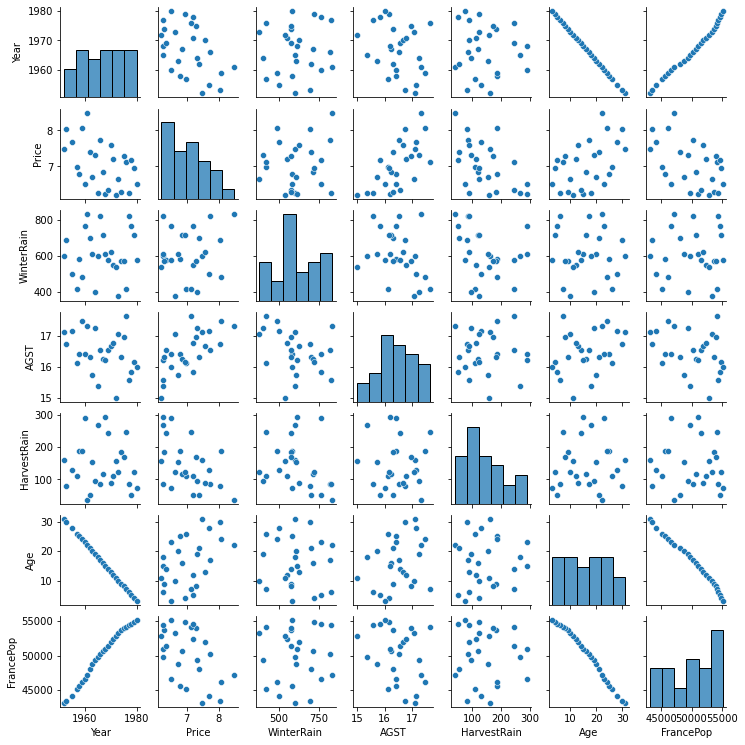

In [9]:
sns.pairplot(df, height=1.5)

We can also plot just the pairwise correlation between all of the variables.

<AxesSubplot:>

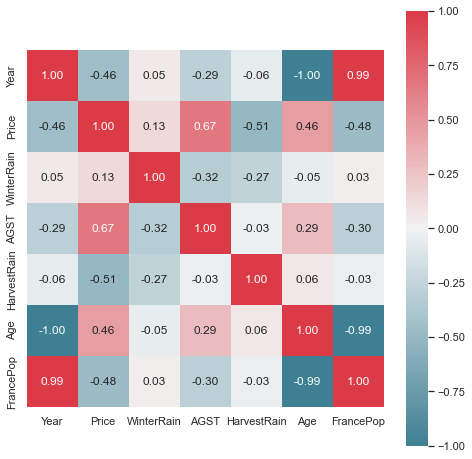

In [10]:
sns.set_theme(style="white")

corr = df.corr()  # computes the correlation matrix
fig, ax = plt.subplots(figsize=(8, 8))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=cmap, square=True, annot=True, fmt=".2f")

Next, we can build a simple linear regression model. We can split the dataset into six *features* (Year, WinterRain, AGST, HarvestRain, Age, and FrancePop), which we will use to predict the *label* (Price).

In [11]:
X = df[['Year', 'WinterRain', 'AGST', 'HarvestRain', 'Age', 'FrancePop']]
y = df[['Price']]
X.shape, y.shape

((27, 6), (27, 1))

In [12]:
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

Our model has been fitted and can now be used to make future predictions! Of course, we should check how our model is doing, so let's output the coefficient of determination (aka R^2 value).

In [13]:
# returns R^2 of the model
r2_score(y, reg.predict(X))

0.8277814822424625

As it turns out, our model is pretty good! To see exactly where the differences between the predictions and the observed values lie, we can use the same model to run a prediction on our input values.

In [14]:
df_pred = pd.concat([pd.DataFrame(reg.predict(X)), y], axis=1)
df_pred.columns = ['Predicted Price', 'Actual Price']
df_pred['error'] = df_pred['Actual Price'] - df_pred['Predicted Price']
df_pred.head()  # remove '.head()' if you want to view the full dataframe

,Predicted Price,Actual Price,error
0,7.723305,7.4950,-0.228305
1,7.877846,8.0393,0.161454
2,7.681668,7.6858,0.004132
3,6.990945,6.9845,-0.006445
4,7.031551,6.7772,-0.254351


Here is a plot of our predicted vs. actual prices:

<AxesSubplot:xlabel='Predicted Price', ylabel='Actual Price'>

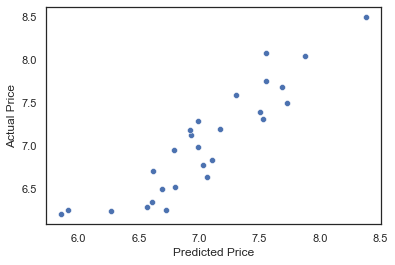

In [15]:
sns.scatterplot(data=df_pred, x='Predicted Price', y='Actual Price')

We can also make a plot of the residuals (errors), shown below.

<AxesSubplot:xlabel='index', ylabel='error'>

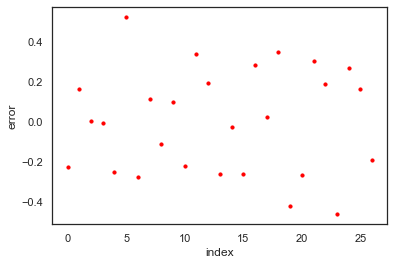

In [16]:
df_pred.reset_index().plot(kind='scatter', x='index', y='error', color=(1,0,0), s=10)

For this model, since we had so little data to work with, we used all of the data to build the model. In general, this is not the best practice as it can lead to overfitting. For a more rigorous approach, we want to use a technique called cross-validation, which involves splitting our data into *training* and *test* sets, which can be seen in the next example.

### Example 2: Automobile Insurance

For this part, we will be using the Automobile Data Set from the UC Irvine Machine Learning Repository (source: https://archive.ics.uci.edu/ml/datasets/Automobile)

> Creator/Donor: Jeffrey C. Schlimmer (Jeffrey.Schlimmer '@' a.gp.cs.cmu.edu) 
>
> Sources: 
> 1) 1985 Model Import Car and Truck Specifications, 1985 Ward's Automotive Yearbook. 
>
> 2) Personal Auto Manuals, Insurance Services Office, 160 Water Street, New York, NY 10038 
>
> 3) Insurance Collision Report, Insurance Institute for Highway Safety, Watergate 600, Washington, DC 20037

In [17]:
df = pd.read_csv('./data/cars/imports-85.data', header=None)
df.columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
              'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 
              'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 
              'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
df

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


Here is a brief summary of the data (quoted from the original publishers):
> This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars. The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process "symboling". A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe. The third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year. 

Unfortunately, unlike the previous dataset (which was relatively complete), this dataset is missing some values. Specifically, if we look at the summary of the data in `./data/cars/imports-85.names`, we notice that the `normalized-losses` attribute is missing 41 data points (a fifth of the data). To simplify our example, we will ignore the `normalized-losses` column entirely. We also notice that a few other rows are missing data points, so we will remove those (be careful when doing this! in general, dealing with missing data is a very complex topic and depends heavily on the exact dataset you are working with - more information on this subject can be found here: https://www.mastersindatascience.org/learning/how-to-deal-with-missing-data/).

In [18]:
# remove the normalized-losses columns, as well as any remaining rows that contain missing data
df = df.drop(['normalized-losses'], axis=1).replace('?', np.nan).dropna().reset_index()

# explicitly convert columns to numerical
df['bore'] = pd.to_numeric(df['bore'])
df['stroke'] = pd.to_numeric(df['stroke'])
df['horsepower'] = pd.to_numeric(df['horsepower'])
df['peak-rpm'] = pd.to_numeric(df['peak-rpm'])
df['price'] = pd.to_numeric(df['price'])

Notice that we went from 205 rows to 193 rows! Luckily, there is enough remaining data for us to work with. 

Notice also that this dataset, unlike the previous dataset we used, contains [categorical data](https://www.datacamp.com/community/tutorials/categorical-data). We will talk about exactly how we address categorical variables later, but for now let's focus on the numerical data first.

Let's extract the numerical features and try to predict the symboling column.

In [19]:
df_numerical = df[df.applymap(np.isreal)].dropna(axis=1)  # extracts numerical rows
df_numerical

,index,symboling,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,2,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,3,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,4,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,200,-1,109.1,188.8,68.9,55.5,2952,141,3.78,3.15,9.5,114,5400,23,28,16845
189,201,-1,109.1,188.8,68.8,55.5,3049,141,3.78,3.15,8.7,160,5300,19,25,19045
190,202,-1,109.1,188.8,68.9,55.5,3012,173,3.58,2.87,8.8,134,5500,18,23,21485
191,203,-1,109.1,188.8,68.9,55.5,3217,145,3.01,3.40,23.0,106,4800,26,27,22470


First, let's split our data into training and test sets. We set aside our test data to evaluate our model later.

In [20]:
X = df_numerical.loc[:, df_numerical.columns != 'symboling']
y = df_numerical[['symboling']]

# the code below creates a train-test split, with 70% of data being used for training and the rest used for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 15, test_size = 0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((135, 15), (135, 1), (58, 15), (58, 1))

In [21]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [22]:
print(f'In-sample (training) R^2 = {reg.score(X_train, y_train)}')
print(f'Out-of-sample (testing) R^2 = {reg.score(X_test, y_test)}')

In-sample (training) R^2 = 0.4696822594733282
Out-of-sample (testing) R^2 = 0.2925857456902411


Notice how this model is much worse than our previous one, especially when we run it on the test data. Let's find ways to improve it!

### One-hot Encoding

First, let's try to add back the categorical data. The technique that is frequently used to is called [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). Essentially this technique involves making a new column for every possible value in a category, and encoding it with a 1 if the sample matches that value. 

In [23]:
df[~df.applymap(np.isreal)].dropna(axis=1)

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi
...,...,...,...,...,...,...,...,...,...,...
188,volvo,gas,std,four,sedan,rwd,front,ohc,four,mpfi
189,volvo,gas,turbo,four,sedan,rwd,front,ohc,four,mpfi
190,volvo,gas,std,four,sedan,rwd,front,ohcv,six,mpfi
191,volvo,diesel,turbo,four,sedan,rwd,front,ohc,six,idi


In [24]:
enc = OneHotEncoder()
categorical = enc.fit_transform(df[~df.applymap(np.isreal)].dropna(axis=1)).toarray()
categorical.shape

(193, 55)

In [25]:
df_categorical = pd.DataFrame(categorical, columns=enc.get_feature_names_out())
df_categorical

,make_alfa-romero,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercedes-benz,...,num-of-cylinders_six,num-of-cylinders_three,num-of-cylinders_twelve,fuel-system_1bbl,fuel-system_2bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [26]:
df_composite = pd.concat([df_numerical, df_categorical], axis=1)
df_composite

,index,symboling,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,...,num-of-cylinders_six,num-of-cylinders_three,num-of-cylinders_twelve,fuel-system_1bbl,fuel-system_2bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
0,0,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,200,-1,109.1,188.8,68.9,55.5,2952,141,3.78,3.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
189,201,-1,109.1,188.8,68.8,55.5,3049,141,3.78,3.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
190,202,-1,109.1,188.8,68.9,55.5,3012,173,3.58,2.87,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
191,203,-1,109.1,188.8,68.9,55.5,3217,145,3.01,3.40,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
X = df_composite.loc[:, df_composite.columns != 'symboling']
y = df_composite[['symboling']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 15, test_size = 0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

reg = LinearRegression()
reg.fit(X_train, y_train)

print(f'In-sample (training) R^2 = {reg.score(X_train, y_train)}')
print(f'Out-of-sample (testing) R^2 = {reg.score(X_test, y_test)}')

In-sample (training) R^2 = 0.9062548170469982
Out-of-sample (testing) R^2 = 0.5791420678013393


### k-fold cross-validation

Relevant reading: https://machinelearningmastery.com/k-fold-cross-validation/

With small datasets, it is difficult to be sure that our model is accurate and robust. Indeed, using different splits can lead to very different models that have varying performances on testing data. Below we use a technique called k-fold cross validation, which involves partitioning our original dataset into k disjoint sets, then trying to train our model using each set as the testing set one time (and using the other k - 1 sets as training data).

In [28]:
X = df_composite.loc[:, df_composite.columns != 'symboling']
y = df_composite[['symboling']]

# custom method to take in a dataset and a model-fitting function (e.g. LinearRegression, Lasso, Ridge)
# perform kfold cross-validation and output the average R^2 using a specified function
def cross_validate(X, y, function, n_splits=10, **kwargs):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=15)

    in_sample_sum = 0
    out_sample_sum = 0

    for train, test in kfold.split(X):
        # print('train: %s, test: %s' % (_.iloc[train], _.iloc[test]))
        X_train = X.iloc[train]
        y_train = y.iloc[train]

        X_test = X.iloc[test]
        y_test = y.iloc[test]

        reg = function(**kwargs)
        reg.fit(X_train, y_train)

        print(f'In-sample (training) R^2 = {reg.score(X_train, y_train)}')
        print(f'Out-of-sample (testing) R^2 = {reg.score(X_test, y_test)}\n')

        in_sample_sum += reg.score(X_train, y_train)
        out_sample_sum += reg.score(X_test, y_test)

    print(f'Average in-sample R^2 = {in_sample_sum / n_splits}')
    print(f'Average out-sample R^2 = {out_sample_sum / n_splits}')
    
    return reg

cross_validate(X, y, LinearRegression)

In-sample (training) R^2 = 0.8878296325898867
Out-of-sample (testing) R^2 = 0.16802883328701423

In-sample (training) R^2 = 0.877511843788378
Out-of-sample (testing) R^2 = 0.6844061904117931

In-sample (training) R^2 = 0.8658559942074849
Out-of-sample (testing) R^2 = 0.7424778292421362

In-sample (training) R^2 = 0.8612874571511933
Out-of-sample (testing) R^2 = 0.7389981179707884

In-sample (training) R^2 = 0.8640162057392835
Out-of-sample (testing) R^2 = 0.7809276445587675

In-sample (training) R^2 = 0.8484940056816385
Out-of-sample (testing) R^2 = 0.7916508226804354

In-sample (training) R^2 = 0.8749682500288409
Out-of-sample (testing) R^2 = 0.28432664049334133

In-sample (training) R^2 = 0.8785295625453413
Out-of-sample (testing) R^2 = 0.04280533766054362

In-sample (training) R^2 = 0.864276209085617
Out-of-sample (testing) R^2 = 0.6807121037404961

In-sample (training) R^2 = 0.8549103190647228
Out-of-sample (testing) R^2 = 0.7973891099408462

Average in-sample R^2 = 0.8677679479882

LinearRegression()

Notice that sometimes the model does very well, but sometimes it performs extremely poorly! How can we do better?

### Addressing Multicollinearity

One reason your model may perform poorly is due to multicollinearity, or having multiple features that are highly correlated with one another. To see if this is the case with any of our features, let's try graphing the pairwise correlation between each pair of features. 

<AxesSubplot:>

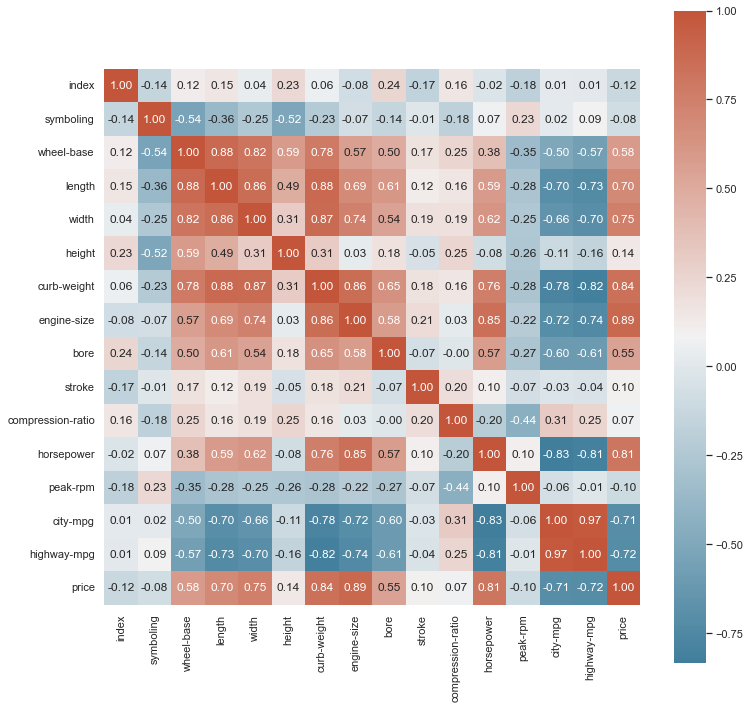

In [29]:
sns.set_theme(style="white")

corr = df_numerical.corr()  # computes the correlation matrix
fig, ax = plt.subplots(figsize=(12, 12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=cmap,
            square=True, annot=True, fmt=".2f")

We observe that many of the features are highly correlated with one another; let's identify a few of them and remove them from our dataset. This is a technique known as feature selection.

In [30]:
df_composite = pd.concat([df_numerical, df_categorical], axis=1)
df_composite = df_composite.drop(['curb-weight', 'city-mpg', 'highway-mpg'], axis=1)

X = df_composite.loc[:, df_composite.columns != 'symboling']
y = df_composite[['symboling']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 15, test_size = 0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

reg = LinearRegression()
reg.fit(X_train, y_train)

print(f'In-sample (training) R^2 = {reg.score(X_train, y_train)}')
print(f'Out-of-sample (testing) R^2 = {reg.score(X_test, y_test)}')

In-sample (training) R^2 = 0.903742990336448
Out-of-sample (testing) R^2 = 0.6050764979116281


Since `symboling` takes on integer values, we can also try rounding our model's raw predictions to see how well they match up with the actual values.

In [31]:
_ = pd.concat([pd.DataFrame(reg.predict(X_test), columns=['predictions raw']), y_test.reset_index()['symboling']], axis=1)
_['predictions rounded'] = np.round(_['predictions raw'])
_.head()

,predictions raw,symboling,predictions rounded
0,0.642832,0,1.0
1,0.354472,0,0.0
2,0.647820,0,1.0
3,0.361231,0,0.0
4,0.317230,1,0.0


### Regularization

In order to prevent our model from overfitting, we can perform regularization. In essence, we add an additional term to our loss function in order to penalize overly complex models; this is usually some function of the coefficients of our final model. 

Two major types of regularization:
L1 - penalty on sum of absolute values of coefficients
L2 - penalty on sum of squares of coefficients

Adding this additional term penalizes models that are overly complex, and also deals with multicollinearity and overfitting. The degree of the penalty can be adjusted by adding a coefficient to the penalty term.

In general, when deciding between whether to use ridge or lasso regression, there are a few things to keep in mind:
- lasso regression is able to set coefficients to zero, and thus can perform feature selection
- in general, given a set of highly correlated features, ridge regression tends to set the coefficients of those features to similar values, while lasso tends to give one of the features a large coefficient and set the others to low or zero values
- thus, lasso tends to perform well if a handful of significant features and the rest are less relevant, while ridge tends to perform well in the presence of many somewhat-useful features

In many cases you can just test both and pick the one that performs better.

When performing ridge or lasso regression, it is generally a good idea to standardize/scale your data before running the regression. This is because we are placing a penalty on the size of the coefficients; if the features are not on similar scales, the penalty will term will be biased towards certain features, which is something we want to avoid.

#### Ridge Regression

In [32]:
df_composite = pd.concat([df_numerical, df_categorical], axis=1)

# scale values before performing ridge or lasso regression
df_composite = pd.DataFrame(StandardScaler().fit_transform(df_composite), columns=df_composite.columns)

X = df_composite.loc[:, df_composite.columns != 'symboling']
y = df_composite[['symboling']]

# the code below creates a train-test split, with 70% of data being used for training and the rest used for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20, test_size = 0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# try different values for alpha
for alpha in [0.01, 0.1, 1, 5, 10, 15, 20, 40, 80, 160, 320, 640]:
    ridgereg = Ridge(alpha=alpha)
    ridgereg.fit(X_train, y_train)

    print(f'alpha = {alpha}')
    print(f'In-sample (training) R^2 = {ridgereg.score(X_train, y_train)}')
    print(f'Out-of-sample (testing) R^2 = {ridgereg.score(X_test, y_test)}\n')

alpha = 0.01
In-sample (training) R^2 = 0.8784824381629265
Out-of-sample (testing) R^2 = 0.6084580595421354

alpha = 0.1
In-sample (training) R^2 = 0.8766077608072441
Out-of-sample (testing) R^2 = 0.6312728088444335

alpha = 1
In-sample (training) R^2 = 0.8715235370140939
Out-of-sample (testing) R^2 = 0.6796121082080268

alpha = 5
In-sample (training) R^2 = 0.863040080305962
Out-of-sample (testing) R^2 = 0.7043783552700851

alpha = 10
In-sample (training) R^2 = 0.8539674826670592
Out-of-sample (testing) R^2 = 0.7160302656590039

alpha = 15
In-sample (training) R^2 = 0.8455219633538593
Out-of-sample (testing) R^2 = 0.722776640712946

alpha = 20
In-sample (training) R^2 = 0.8375518460584358
Out-of-sample (testing) R^2 = 0.7272737838570711

alpha = 40
In-sample (training) R^2 = 0.8093989017280834
Out-of-sample (testing) R^2 = 0.7346643976791807

alpha = 80
In-sample (training) R^2 = 0.7641871109895937
Out-of-sample (testing) R^2 = 0.729065397731237

alpha = 160
In-sample (training) R^2 = 

In [33]:
df_composite = pd.concat([df_numerical, df_categorical], axis=1)

scaler = StandardScaler()
df_composite = pd.DataFrame(scaler.fit_transform(df_composite), columns=df_composite.columns)

X = df_composite.loc[:, df_composite.columns != 'symboling']
y = df_composite[['symboling']]

ridgereg = cross_validate(X, y, Ridge, alpha=20)

In-sample (training) R^2 = 0.8453614954056422
Out-of-sample (testing) R^2 = 0.5143399086864867

In-sample (training) R^2 = 0.840141881644308
Out-of-sample (testing) R^2 = 0.6949680051310321

In-sample (training) R^2 = 0.8325825649850299
Out-of-sample (testing) R^2 = 0.754358186124583

In-sample (training) R^2 = 0.8253436394509192
Out-of-sample (testing) R^2 = 0.7199824202618091

In-sample (training) R^2 = 0.8306858975669635
Out-of-sample (testing) R^2 = 0.7490604213245209

In-sample (training) R^2 = 0.8119189838996329
Out-of-sample (testing) R^2 = 0.9137045962340915

In-sample (training) R^2 = 0.8420243646886841
Out-of-sample (testing) R^2 = 0.4004338489706988

In-sample (training) R^2 = 0.839989969674684
Out-of-sample (testing) R^2 = 0.4228694714070532

In-sample (training) R^2 = 0.8376846587218105
Out-of-sample (testing) R^2 = 0.6682142737416217

In-sample (training) R^2 = 0.8235024725507065
Out-of-sample (testing) R^2 = 0.7886100086938947

Average in-sample R^2 = 0.8329235928588382


#### Lasso Regression

In [34]:
df_composite = pd.concat([df_numerical, df_categorical], axis=1)

scaler = StandardScaler()
df_composite = pd.DataFrame(scaler.fit_transform(df_composite), columns=df_composite.columns)

X = df_composite.loc[:, df_composite.columns != 'symboling']
y = df_composite[['symboling']]

n_splits = 10
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=15)

in_sample_sum = 0
out_sample_sum = 0

lassoreg = cross_validate(X, y, Lasso, alpha=0.01)

In-sample (training) R^2 = 0.8520981802080771
Out-of-sample (testing) R^2 = 0.5193332527512908

In-sample (training) R^2 = 0.8463741835429862
Out-of-sample (testing) R^2 = 0.6930154540451636

In-sample (training) R^2 = 0.8360194497736685
Out-of-sample (testing) R^2 = 0.7640418598297207

In-sample (training) R^2 = 0.8280747927692029
Out-of-sample (testing) R^2 = 0.763474920953386

In-sample (training) R^2 = 0.833512148606216
Out-of-sample (testing) R^2 = 0.8000706685965573

In-sample (training) R^2 = 0.8161775371285336
Out-of-sample (testing) R^2 = 0.9189983011290161

In-sample (training) R^2 = 0.8452042659802645
Out-of-sample (testing) R^2 = 0.4358840218216349

In-sample (training) R^2 = 0.8431061230358212
Out-of-sample (testing) R^2 = 0.4126779053979063

In-sample (training) R^2 = 0.8419533685157948
Out-of-sample (testing) R^2 = 0.7065888385283174

In-sample (training) R^2 = 0.8259534882389464
Out-of-sample (testing) R^2 = 0.7991171611897978

Average in-sample R^2 = 0.8368473537799511

We also output the coefficients of our different models to see what is happening (for convenience we use the coefficients from the last iteration of the kfold-cross validation). Each coefficient corresponds to one feature in our dataset.

In [35]:
ridgereg.coef_

array([[-0.04607722, -0.21361952, -0.06103813,  0.03400145, -0.17099415,
         0.00835091,  0.06603999,  0.04170054, -0.0195817 ,  0.01432747,
        -0.00145392,  0.00369085, -0.01874026,  0.03408151, -0.03119139,
        -0.04753069,  0.22113765, -0.03055997, -0.06055415, -0.06097585,
        -0.05746066, -0.04851648, -0.04167676, -0.03418448, -0.03984702,
        -0.0227408 ,  0.07199398,  0.02111467,  0.02195619, -0.01103707,
         0.06836186,  0.25283171, -0.03767891, -0.12237132,  0.23489726,
        -0.20448613, -0.01597026,  0.01597026, -0.01120276,  0.01120276,
        -0.1514212 ,  0.1514212 ,  0.09620366,  0.03326047,  0.03326165,
        -0.06129236, -0.02518381,  0.01361759, -0.0602573 ,  0.05581329,
        -0.00620342,  0.00620342,  0.0522343 ,  0.02107944, -0.00863348,
        -0.03111761, -0.02211118,  0.06301721, -0.07369586,  0.01318143,
         0.0232012 ,  0.        , -0.07858357, -0.04210093,  0.01940406,
        -0.01597026,  0.08027722, -0.01259366,  0.0

In [36]:
lassoreg.coef_

array([ 0.00000000e+00, -2.95741397e-01, -0.00000000e+00,  8.93589152e-03,
       -2.06174028e-01,  0.00000000e+00,  6.15586161e-02,  4.25270265e-02,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -2.52338259e-02,
        2.91972108e-01, -0.00000000e+00, -2.82556020e-02, -1.67407904e-02,
       -3.79649445e-02, -2.99127294e-02, -3.96763719e-03,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  1.07797818e-01,  3.91720853e-02,
        8.35271924e-02,  1.18840527e-03,  6.52368273e-02,  3.03830741e-01,
       -2.50611843e-02, -8.30130793e-02,  2.73492417e-01, -1.95788301e-01,
       -0.00000000e+00,  0.00000000e+00, -4.02935380e-03,  2.77705413e-16,
       -3.26781948e-01,  3.84385046e-17,  7.23841312e-02,  8.98360782e-03,
        0.00000000e+00, -6.61590781e-02, -2.46056988e-03,  0.00000000e+00,
       -6.55368804e-02,  8.25733940e-02, -0.00000000e+00,  0.00000000e+00,
        2.69493906e-02,  

As you can see, lasso regression is able to perform feature selection (coefficients set to zero above), whereas ridge has kept all of the features but set the highly correlated ones to similar values.

Below is a comparison of the predicted symboling vs the actual values; note that we scaled all of our data before performing ridge and lasso regression, so the symboling no longer takes values from -3 to 3.

In [37]:
pd.concat([pd.DataFrame(lassoreg.predict(X_test), columns=['predicted symboling']), y_test.reset_index()['symboling']], axis=1).head()

,predicted symboling,symboling
0,0.718767,0.975410
1,-1.144936,-1.458911
2,-1.493388,-1.458911
3,-0.675273,0.163970
4,0.253603,0.163970


See also: elasticnet (combines L1 and L2 regularization)